# Load in the packages

In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

plus_minus = u"\u00B1"

# Load in the data files

In [42]:
# load in sample names from the folder names in the directory
path = os.getcwd()
sample_names = natsorted([n for n in os.listdir() if '.' not in n])

# load in the power reference and index by the currents rounded to the first decimal place
ref = pd.read_csv('PowerCurrent_Averaged.csv', index_col='currents')
ref.index = np.round(ref.index, decimals = 1)

# load in the SQ limit dataframe
sq = pd.read_csv('SQ.csv', index_col='Eg')

fids = {}
for n in sample_names:
    s_path = os.path.join(path, n)
    fids[n] = natsorted([os.path.join(s_path, f) for f in os.listdir(s_path) if '.csv' in f])

currents = {}
data = {}
for n in sample_names:
    currents[n] = [np.round(float(f.split("_")[-1][:-4]), decimals=1) for f in fids[n]]
    data[n] = {}
    data[n]['powers'] = np.array(ref['power'][currents[n]])*1000 #watts to mW

# Define the functions for analysis

In [43]:
def load_plqy(fid):

    """Simple function to load .csv plqy data

    Args:
        fid (str): file path, should be .csv

    Returns:
        pd.DataFrame: a data frame containing the six scan types necessary to calculate PLQY
    """

    df = pd.read_csv(fid)
    
    return df
    
def calc_plqy_deMello(data: pd.DataFrame, sample_wl: float, sample_resp: float, laser_wl: float, laser_resp: float):

    """A function to calculate the PLQY based in a publication by de Mello et al.
       The most widely used method for calculating PLQY.
       https://doi.org/10.1002/adma.19970090308

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
        sample_wl (float): the peak emission wavelength of the sample
        sample_resp (float): the responsivity of the detector at sample_wl
        laser_wl (float): the emission wavelength of the laser. Probably 532.0nm
        laser_resp (float): the responsivity of the detector at the laser_wl

    Returns:
        tuple: (PLQY, PLQY error), resported as fractional, not percentage
    """

    E_in = data['in_lp'].mean()
    E_in_err = data['in_lp'].std()/E_in

    E_out = data['out_lp'].mean()
    E_out_err = data['out_lp'].std()/E_out

    X_in = data['in_nolp'].mean() - E_in
    X_in_err = (data['in_nolp'].std()/X_in) + E_in_err

    X_out = data['out_nolp'].mean() - E_out
    X_out_err = (data['out_nolp'].std()/X_out) + E_out_err

    X_empty = data['empty_nolp'].mean() - data['empty_lp'].mean()
    X_empty_err = (data['empty_nolp'].std()/data['empty_nolp'].mean()) + (data['empty_lp'].std()/data['empty_lp'].mean())

    E_in = E_in*(sample_wl/sample_resp)
    E_out = E_out*(sample_wl/sample_resp)

    X_in = X_in*(laser_wl/laser_resp)
    X_out = X_out*(laser_wl/laser_resp)
    X_empty = X_empty*(laser_wl/laser_resp)

    a = (X_out-X_in)/X_out
    a_err = np.sqrt(((X_out_err + X_in_err)**2) + (X_out_err**2))

    plqy = (E_in-(1-a)*E_out)/(X_empty*a)
    plqy_err = np.sqrt((E_in_err**2) + ((E_out_err + a_err)**2) + (X_empty_err**2))

    return plqy, plqy_err*plqy

def plot_signals(data: pd.DataFrame):

    """Janky plots of the individual signals over the course of the measurement.
       Could be useful to have a quick look at what might be throwing off your measurement

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
    """

    fig, axs = plt.subplots(3,2, figsize = (8,6), dpi = 300)
    axs = axs.flatten()
    for i,col in enumerate(data.columns):
        axs[i].plot(data[col], label = col)
        axs[i].set_xticks([])
        axs[i].set_title(col)
        axs[i].ticklabel_format(axis='both', style='scientific', scilimits=(0,0))
        
    plt.tight_layout()

def get_responsivity(emission_wl):
    """internal function to get the respnsivity of the detector at the emission wavelength

    Args:
        emission_wl (float): the mean emission wavelength of the sample

    Returns:
        float: the responsivity, arbitrary units
    """
    try:
        resp = pd.read_csv('Detector_Responsivity.csv')


        return float(resp['Responsivity'][resp['Wavelength'] == emission_wl])

    except: # if not, tell the user to do so
        print(f'Detector_Responsivity.csv not able to load...check code')

# Calculate PLQY and data

Modify EMISSION_WL value dependent on bandgap/PL spectra

In [44]:
EMISSION_WL = 742  #modify this based on bandgap
LASER_WL = 532
LASER_SPOT_SIZE = 0.066 #cm2
kT = 0.026 #eV
REFLECTION_LOSSES = 0.08 # fraction of 1 taken off of the Jsc to make implied curve more real

EMISSION_RESP = get_responsivity(EMISSION_WL)
LASER_RESP = get_responsivity(LASER_WL)

In [45]:
for n in sample_names:
    temp_plqys = []
    temp_errs = []
    
    for fid in tqdm(fids[n]):

        deMello = calc_plqy_deMello(load_plqy(fid), EMISSION_WL, EMISSION_RESP, LASER_WL, LASER_RESP)
        temp_plqys.append(deMello[0])
        temp_errs.append(deMello[1])

 
    data[n]['plqy'] = np.array(temp_plqys)
    data[n]['plqy_err'] = np.array(temp_errs)
    
    #i added this
    data[n]['plqy'][data[n]['plqy'] < 0] = np.nan
    #
    data[n]['Eg'] = np.round(1240/EMISSION_WL, decimals=2)
    data[n]['Voc_rad'] = sq['Voc'][data[n]['Eg']]
    data[n]['Jsc_rad'] = sq['Jsc'][data[n]['Eg']]
    data[n]['Suns'] = (data[n]['powers']/LASER_SPOT_SIZE)/sq['laser power'][data[n]['Eg']]

    
    data[n]['qfls'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns']*data[n]['plqy'])
    data[n]['qfls_err'] = np.log(1 + data[n]['plqy_err']/data[n]['plqy'])
    data[n]['qfls_rad'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns'])

    data[n]['implied_current'] = data[n]['Jsc_rad']*(1-REFLECTION_LOSSES)*(1-data[n]['Suns'])
    data[n]['implied_current_limit'] = data[n]['Jsc_rad']*(1-data[n]['Suns'])
   
    

100%|██████████| 25/25 [00:00<00:00, 834.81it/s]


### Alter the descriptions per experiment:

In [46]:
sample_names_description = {
    'S0': '2PACz_0.6mg_1',
    'S1': '2PACz_2.0mg',
    'S2': '4PACz_0.6mg_1',
    'S3': '4PACz_2.0mg',
    'S4': '2PACz_0.6mg_2',
    'S5': '2PACz_1.2mg + 3AP',
    'S6': '4PACz_0.6mg_2',
    'S7': '4PACz_1.2mg + 3AP',
}

# Log Plot of Irradiance vs. PLQY

Unfiltered:

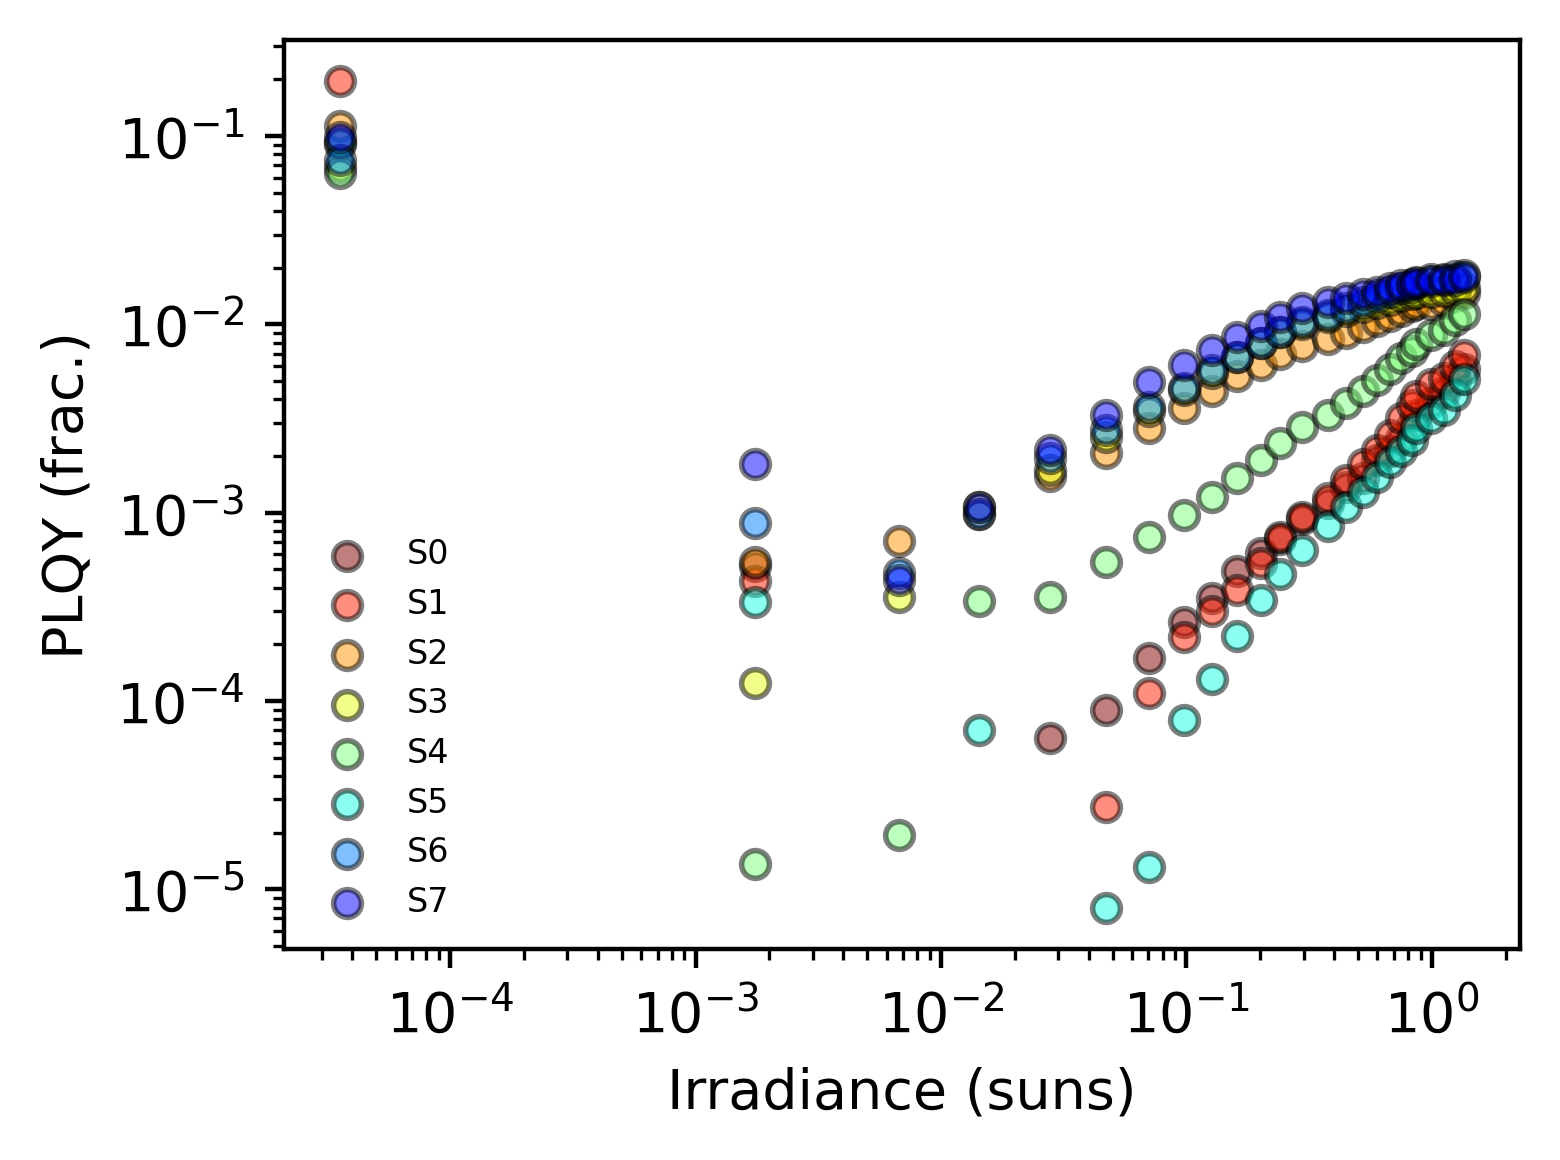

In [47]:
fig, axs = plt.subplots(1,1,figsize = (4,3), dpi = 400)

colors = plt.cm.jet(np.linspace(0,1,9))[::-1]

for i,n in enumerate(sample_names):

    x = data[n]['Suns']
    y = data[n]['plqy']
    y_error = data[n]['plqy_err']

    axs.scatter(x,y,facecolor = colors[i], alpha = 0.5, edgecolors = 'black', s = 25, label = n.replace('_', ', ').replace('0p', '0.'))
    #axs.errorbar(x, y, yerr = y_error, color = colors[i], alpha = 0.5, fmt='none')

    #if len(x) > 0:   
        #x_fit = np.log(x)[1:]
        #y_fit = np.log(y)[1:]
        #a,b,c = np.polyfit(x_fit, y_fit, 2)
        #axs.plot(x, np.exp(a*np.log(x)*np.log(x) + b*np.log(x) + c), linestyle = 'solid', alpha = 0.5, color = colors[i])

axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylabel('PLQY (frac.)')
#axs.set_ylim(top = 1e0, bottom = 1e-5)
#axs.set_xlim(1e-3,)
axs.set_xlabel('Irradiance (suns)')
axs.legend(fontsize = 6, frameon = False)

plt.tight_layout()
#plt.savefig("PLQY.png")

Filter the data, use sorted colors and sample descriptions

Sample S0: Dropped 4 data points
Sample S1: Dropped 5 data points
Sample S2: Dropped 1 data points
Sample S3: Dropped 1 data points
Sample S4: Dropped 1 data points
Sample S5: Dropped 5 data points
Sample S6: Dropped 1 data points
Sample S7: Dropped 2 data points


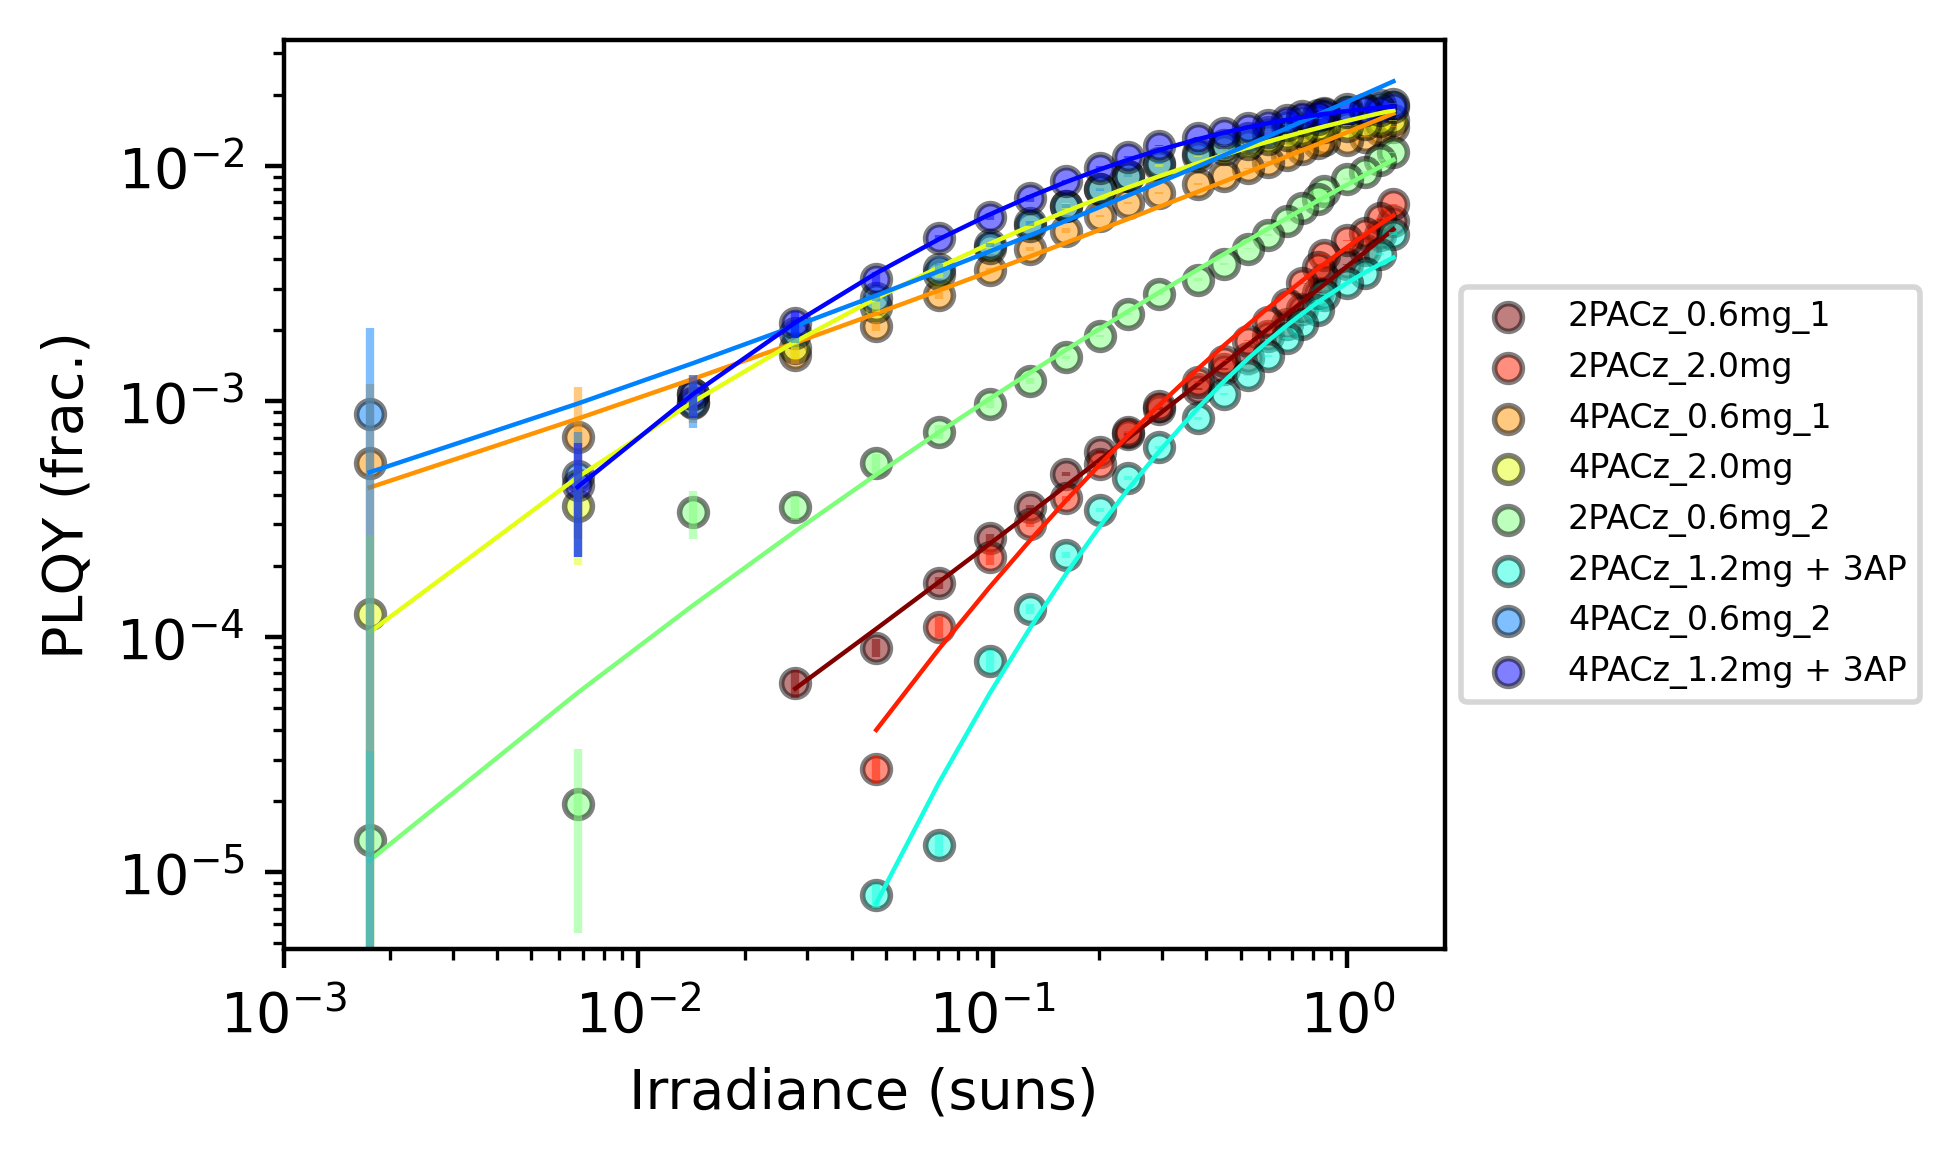

In [48]:
#Filtered PLQY
def plot_with_filtered_data(data, sample_names, sample_colors):
    fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=400)
    
    x_filtered = {}
    y_filtered = {}  # To store the retained y values
    y_error_filtered = {}  # To store the retained y_error values
    dropped_points = {}  # To store the number of dropped points for each sample

    for i, n in enumerate(sample_names):
        x = data[n]['Suns']
        y = data[n]['plqy']
        y_error = data[n]['plqy_err']

        # Ensure data is sorted in descending order for filtering
        sorted_indices = np.argsort(x)[::-1]
        x = np.array(x)[sorted_indices]
        y = np.array(y)[sorted_indices]
        y_error = np.array(y_error)[sorted_indices]

        initial_length = len(x)  # Initial number of data points

        # Remove NaN or infinite values
        valid_indices = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
        x = x[valid_indices]
        y = y[valid_indices]
        y_error = y_error[valid_indices]

        while True:
            # Fit the data
            reg = LinearRegression().fit(np.log(x).reshape(-1, 1), np.log(y))
            predictions = reg.predict(np.log(x).reshape(-1, 1))
            
            # Calculate r-squared
            r2 = r2_score(np.log(y), predictions)

            if r2 >= 0.93 or len(x) <= 2:  # Stop if r^2 is satisfactory or if too few points remain
                break
            
            # Exclude the smallest x-value (i.e., the last value in our sorted list)
            x = x[:-1]
            y = y[:-1]
            y_error = y_error[:-1]

        # Quadratic fit
        coefficients = np.polyfit(np.log(x), np.log(y), 2)
        quadratic_fit = np.polyval(coefficients, np.log(x))

        # Save filtered data
        x_filtered[n] = x
        y_filtered[n] = y  # Store the retained y values
        y_error_filtered[n] = y_error  # Store the retained y_error values
        dropped_points[n] = initial_length - len(x)  # Calculate and store the number of dropped points

        print(f"Sample {n}: Dropped {dropped_points[n]} data points")

        axs.scatter(x, y, color = colors[i], alpha = 0.5, edgecolors = 'black', s = 25, label = sample_names_description[n]
)
        axs.errorbar(x, y, yerr=y_error, color=colors[i], alpha=0.5, fmt='none')
        axs.plot(x, np.exp(quadratic_fit), linestyle='-', color=colors[i], lw = 0.8)  # Plot quadratic fit

    axs.set_yscale('log')
    axs.set_xscale('log')
    axs.set_ylabel('PLQY (frac.)')
    axs.set_xlabel('Irradiance (suns)')
    axs.set_xlim(1e-3,)
    axs.legend(fontsize=6, frameon=True, loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.title("PLQY vs. Irradiance")
    plt.tight_layout()
    plt.savefig("PLQY.png", facecolor='white', bbox_inches='tight')
    
    return x_filtered, y_filtered, y_error_filtered, dropped_points

# Call the function:
x_filtered_data, y_filtered_data, y_error_filtered_data, dropped_points = plot_with_filtered_data(data, sample_names, colors)


## QFLS, Ideality factor

start_index = 4
start_index = 5
start_index = 1
start_index = 1
start_index = 1
start_index = 5
start_index = 1
start_index = 2


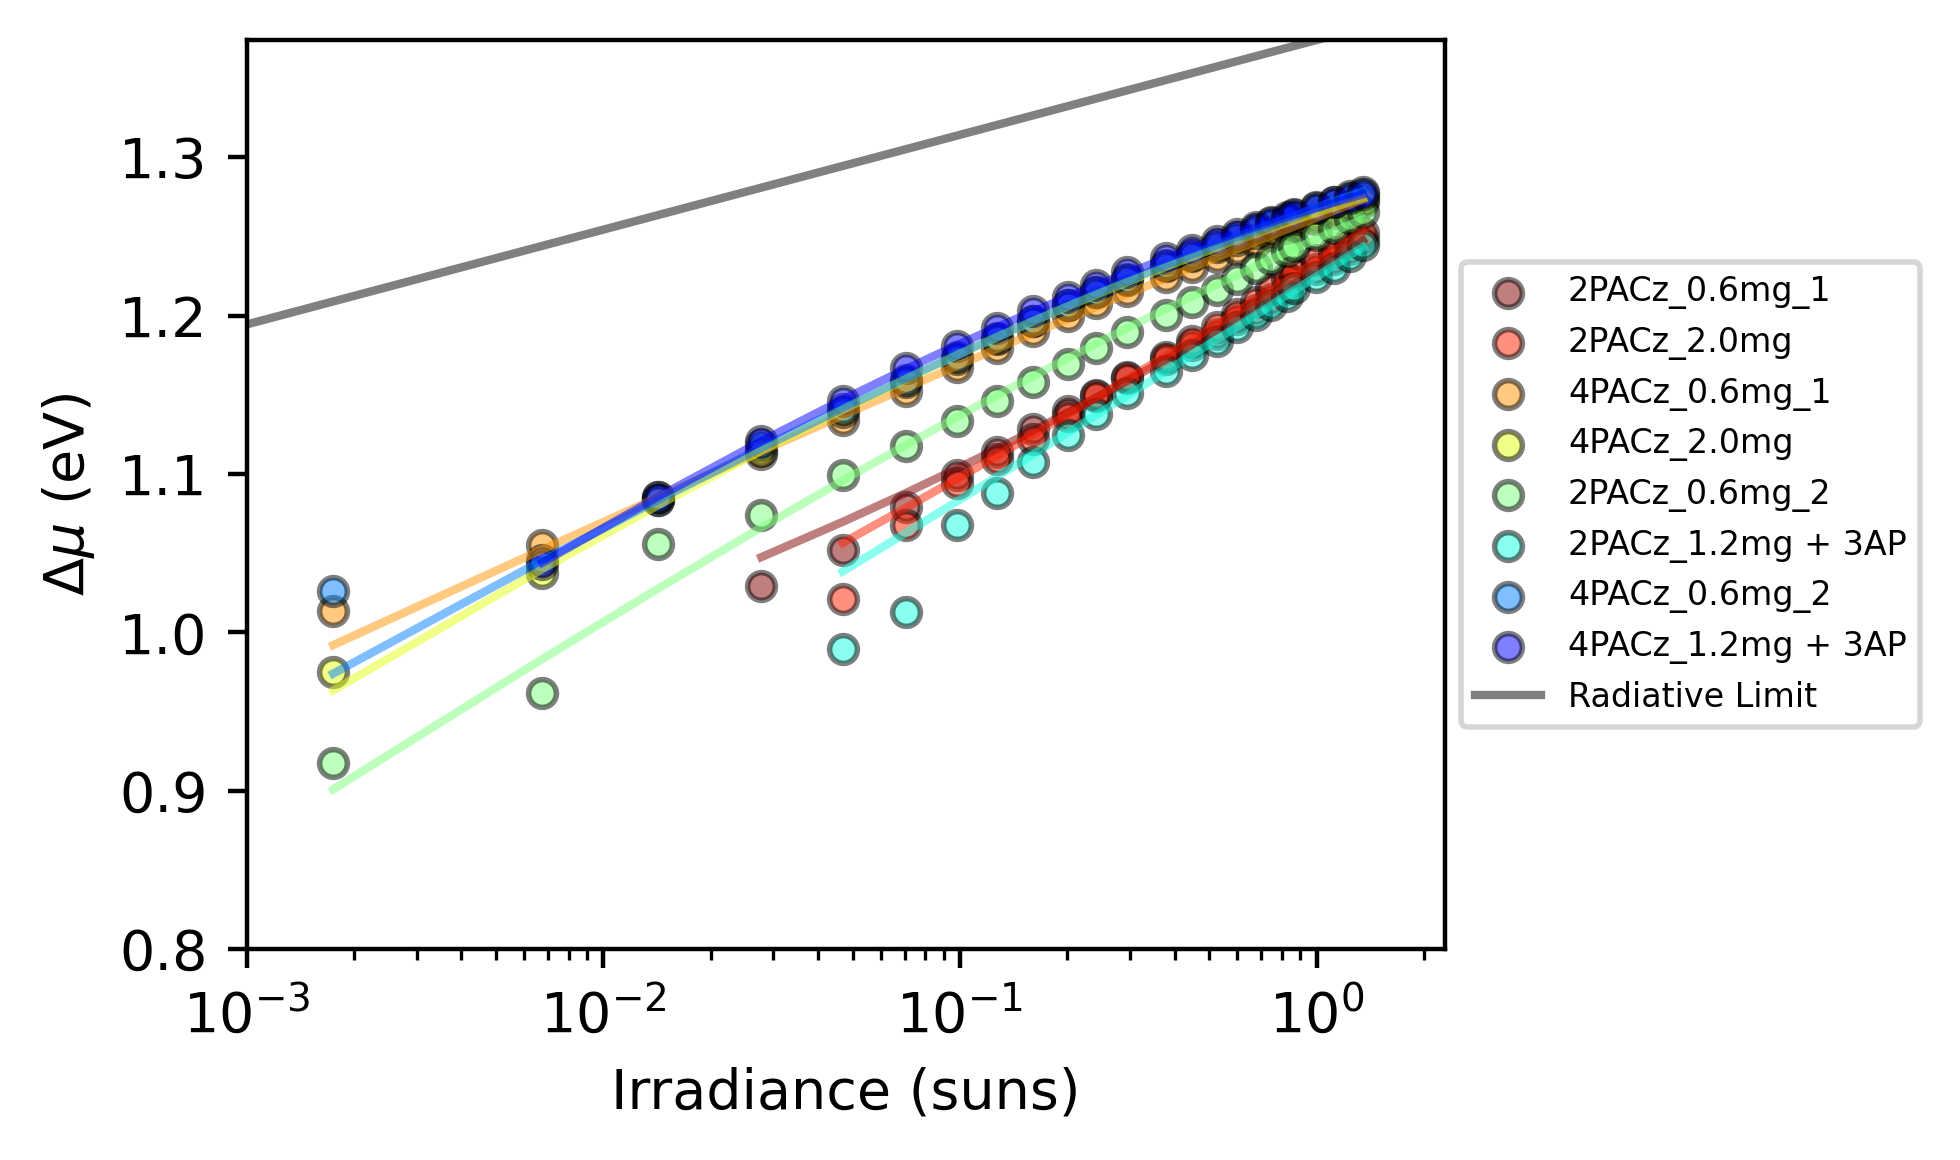

In [49]:
#QFLS filtered
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=400)

colors = plt.cm.jet(np.linspace(0, 1, 9))[::-1]

for i, n in enumerate(sample_names):
    # Calculate the starting index based on the length of filtered data
    start_index = len(data[n]['Suns']) - len(x_filtered_data[n])
    print("start_index =", start_index)

    x = data[n]['Suns'][start_index:]
    y = data[n]['qfls'][start_index:]
    y_error = data[n]['qfls_err'][start_index:]
    axs.scatter(x, y, facecolor=colors[i], alpha=0.5, edgecolors='black', s=25, label=sample_names_description[n])
    #axs.errorbar(x, y, yerr=y_error, color=colors[i], alpha=0.5, fmt='none')

    if len(x) > 0:
        x_fit = np.log(x)[start_index:]
        y_fit = np.log(y)[start_index:]
        a, b, c = np.polyfit(x_fit, y_fit, 2)
        best_fit = np.exp(a * np.log(x) * np.log(x) + b * np.log(x) + c)

        data[n]['best_fit'] = best_fit

        axs.plot(x, best_fit, linestyle='solid', alpha=0.5, color=colors[i])

axs.plot(data[n]['Suns'], data[n]['qfls_rad'], label='Radiative Limit', color='gray')

axs.set_xscale('log')

axs.set_ylabel(r'$\Delta\mu$ (eV)')

axs.set_ylim(bottom=0.8, top=data[n]['Voc_rad'])

axs.set_xlim(1e-3)

axs.set_xlabel('Irradiance (suns)')

axs.legend(fontsize=6, frameon=True, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("QFLS", facecolor='white', bbox_inches='tight')


## JV, PCE

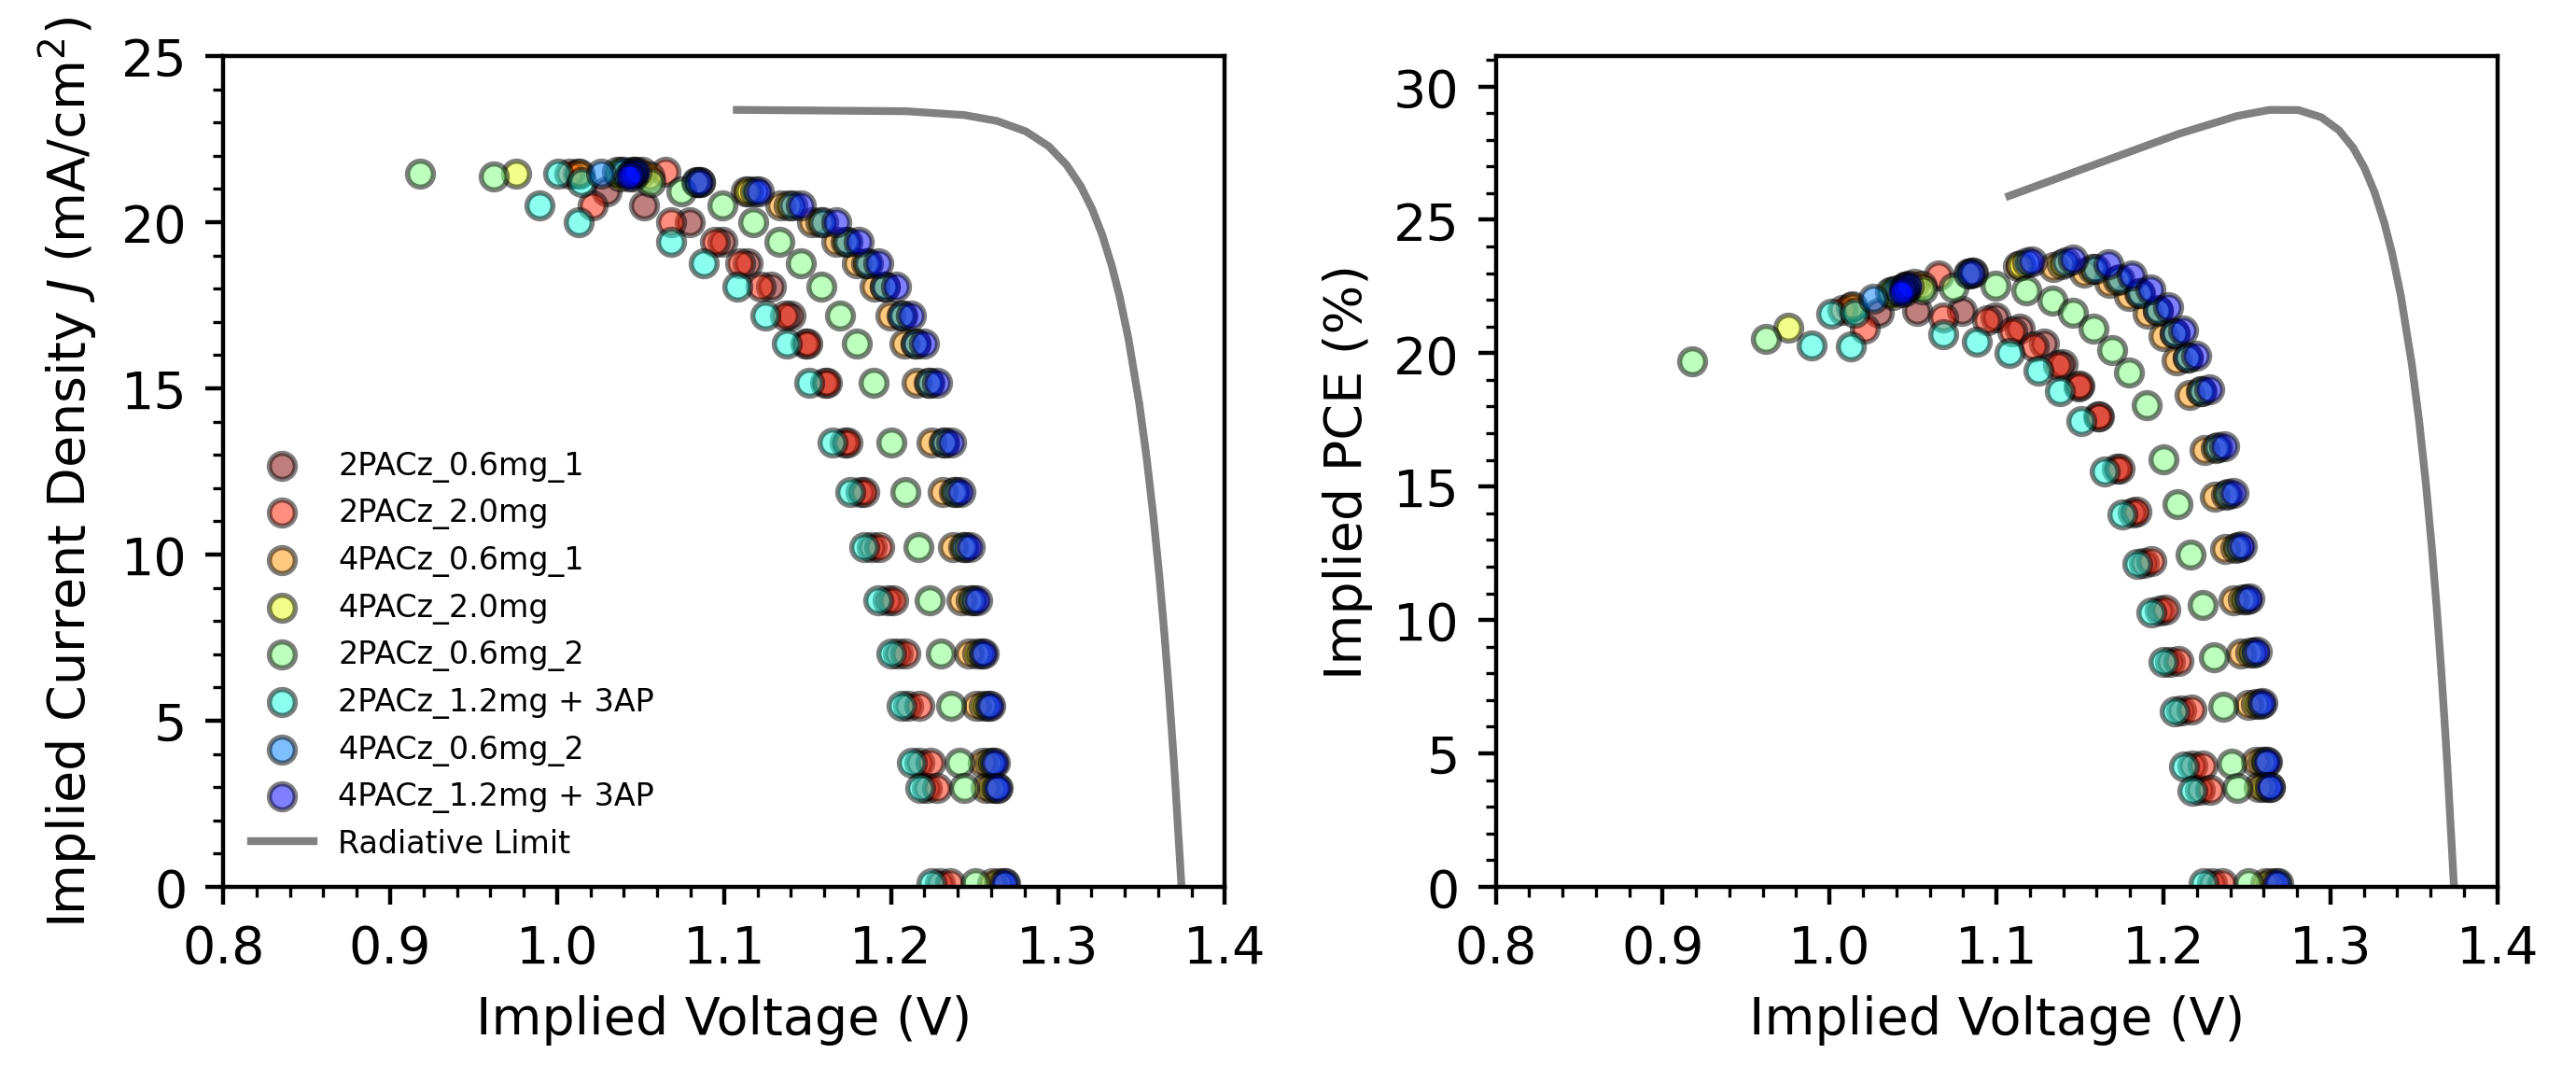

In [50]:
#JV and PCE Unfiltered- no points dropped
fig, axs = plt.subplots(1,2,figsize = (7,3), dpi = 400)

colors = plt.cm.jet(np.linspace(0,1,9))[::-1]

for i,n in enumerate(sample_names):

    x = data[n]['qfls']
    x_error = data[n]['qfls_err']
    y = data[n]['implied_current']
    axs[0].scatter(x,y,facecolor = colors[i], alpha = 0.5, edgecolors = 'black', s = 25, label=sample_names_description[n])
    axs[1].scatter(x, x*y,facecolor = colors[i], alpha = 0.5, edgecolors = 'black', s = 25, label=sample_names_description[n])

axs[0].plot(data[n]['qfls_rad'], data[n]['implied_current_limit'] , label = 'Radiative Limit', color = 'gray')
axs[1].plot(data[n]['qfls_rad'], data[n]['implied_current_limit']*data[n]['qfls_rad'] , label = 'Radiative Limit', color = 'gray')

axs[0].set_xlabel('Implied Voltage (V)')
axs[0].set_ylabel(r'Implied Current Density $J$ (mA/cm$^{2}$)')

axs[1].set_xlabel('Implied Voltage (V)')
axs[1].set_ylabel('Implied PCE (%)')

axs[0].set_ylim(bottom = 0, top = 25)
axs[0].set_xlim(left = 0.8, right = np.ceil(10*data[n]['Voc_rad'])/10)

axs[1].set_ylim(bottom = 0,)
axs[1].set_xlim(left = 0.8, right = np.ceil(10*data[n]['Voc_rad'])/10)

axs[0].legend(fontsize = 6, frameon = False, loc = 'lower left')

axs[0].minorticks_on()
axs[1].minorticks_on()

plt.tight_layout()
#plt.savefig("iJV, PCE unfiltered", facecolor='white', bbox_inches='tight')

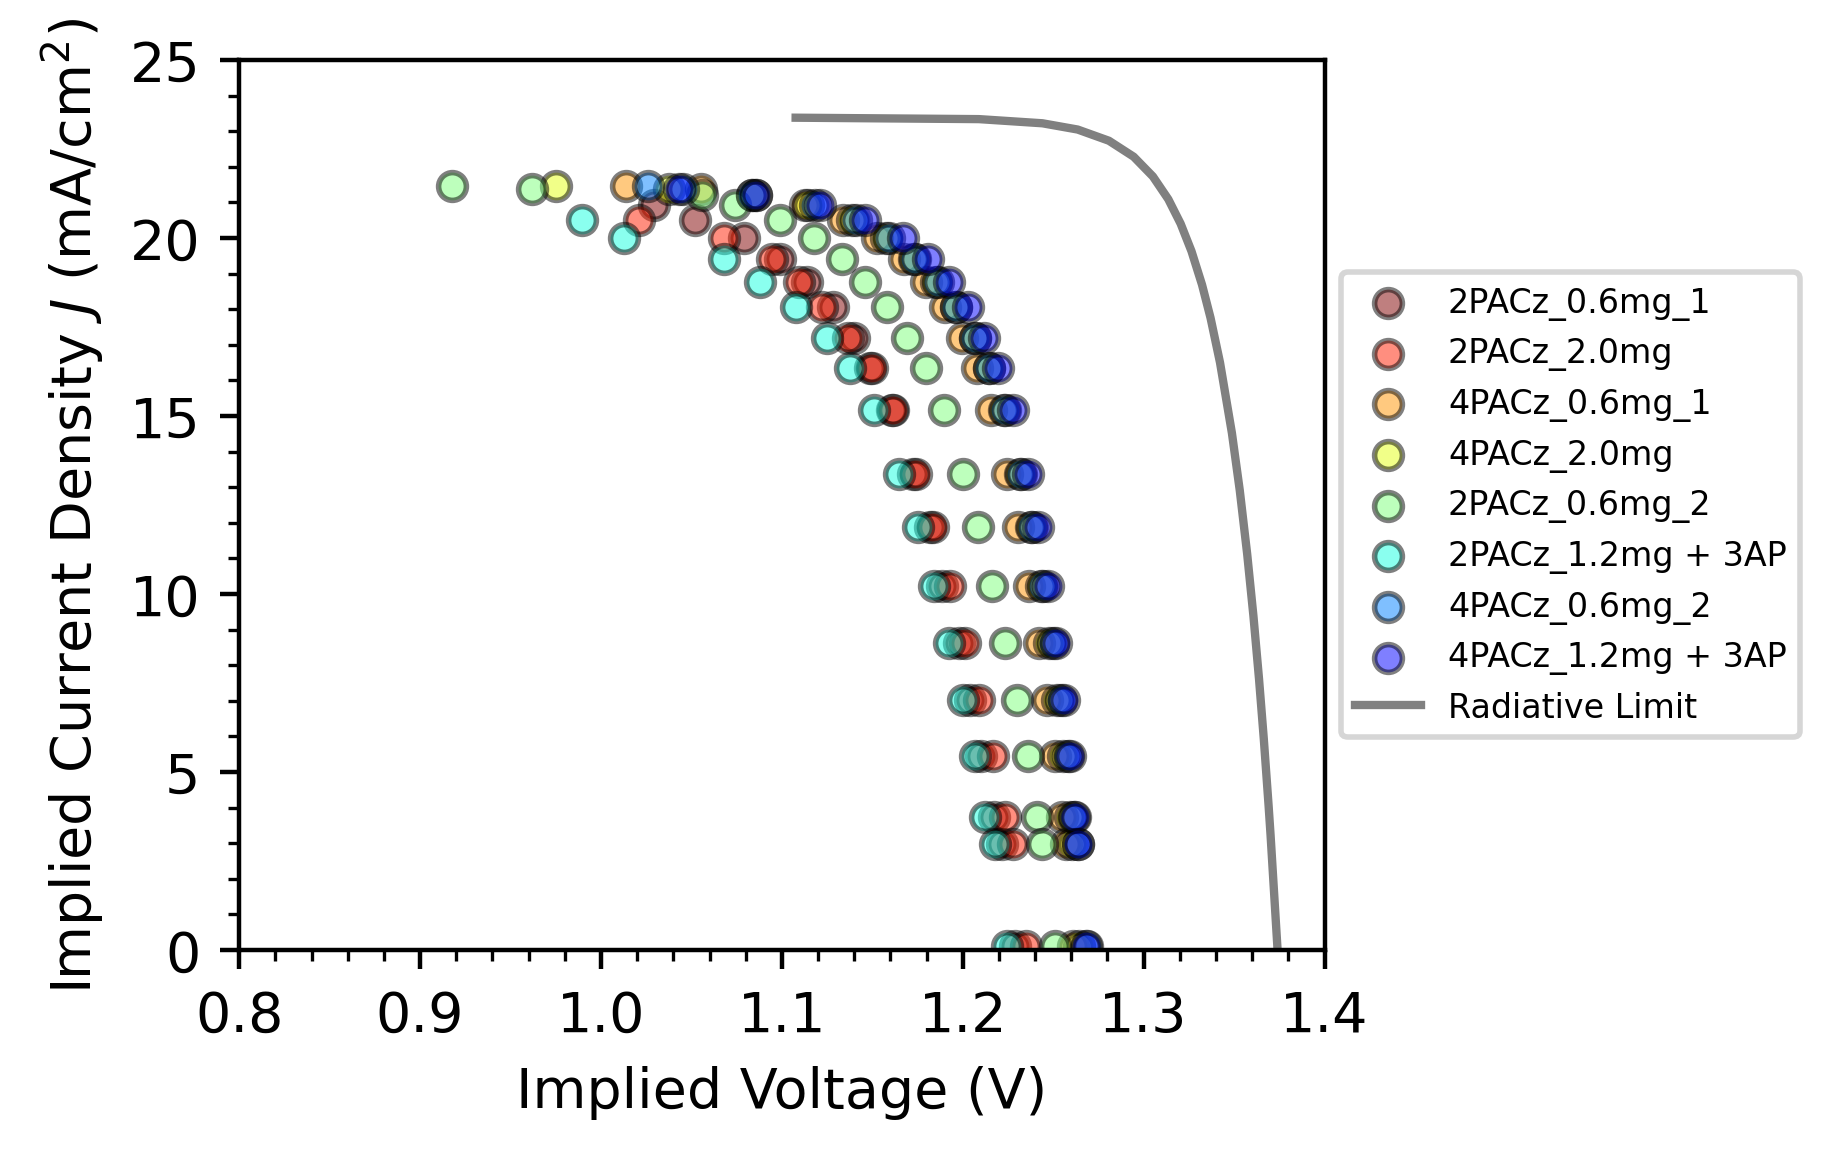

In [51]:
#JV filtered
fig, axs = plt.subplots(1, 1, figsize=(4.7, 3), dpi=400)

colors = plt.cm.jet(np.linspace(0, 1, 9))[::-1]

for i, n in enumerate(sample_names):

    # Calculate the starting index based on the length of filtered data
    start_index = len(data[n]['Suns']) - len(x_filtered_data[n])

    x = data[n]['qfls'][start_index:]
    x_error = data[n]['qfls_err'][start_index:]
    y = data[n]['implied_current'][start_index:]
    axs.scatter(x, y, facecolor=colors[i], alpha=0.5, edgecolors='black', s=25, label=sample_names_description[n])

axs.plot(data[n]['qfls_rad'], data[n]['implied_current_limit'], label='Radiative Limit', color='gray')

axs.set_xlabel('Implied Voltage (V)')
axs.set_ylabel(r'Implied Current Density $J$ (mA/cm$^{2}$)')

axs.set_ylim(bottom=0, top=25)
axs.set_xlim(left=0.8, right=np.ceil(10 * data[n]['Voc_rad']) / 10)

axs.legend(fontsize=6, frameon=True, loc='center left', bbox_to_anchor=(1, 0.5))

axs.minorticks_on()

plt.tight_layout()
plt.savefig("iJV_filtered", facecolor='white', bbox_inches='tight')

## Voc @ 1 sun

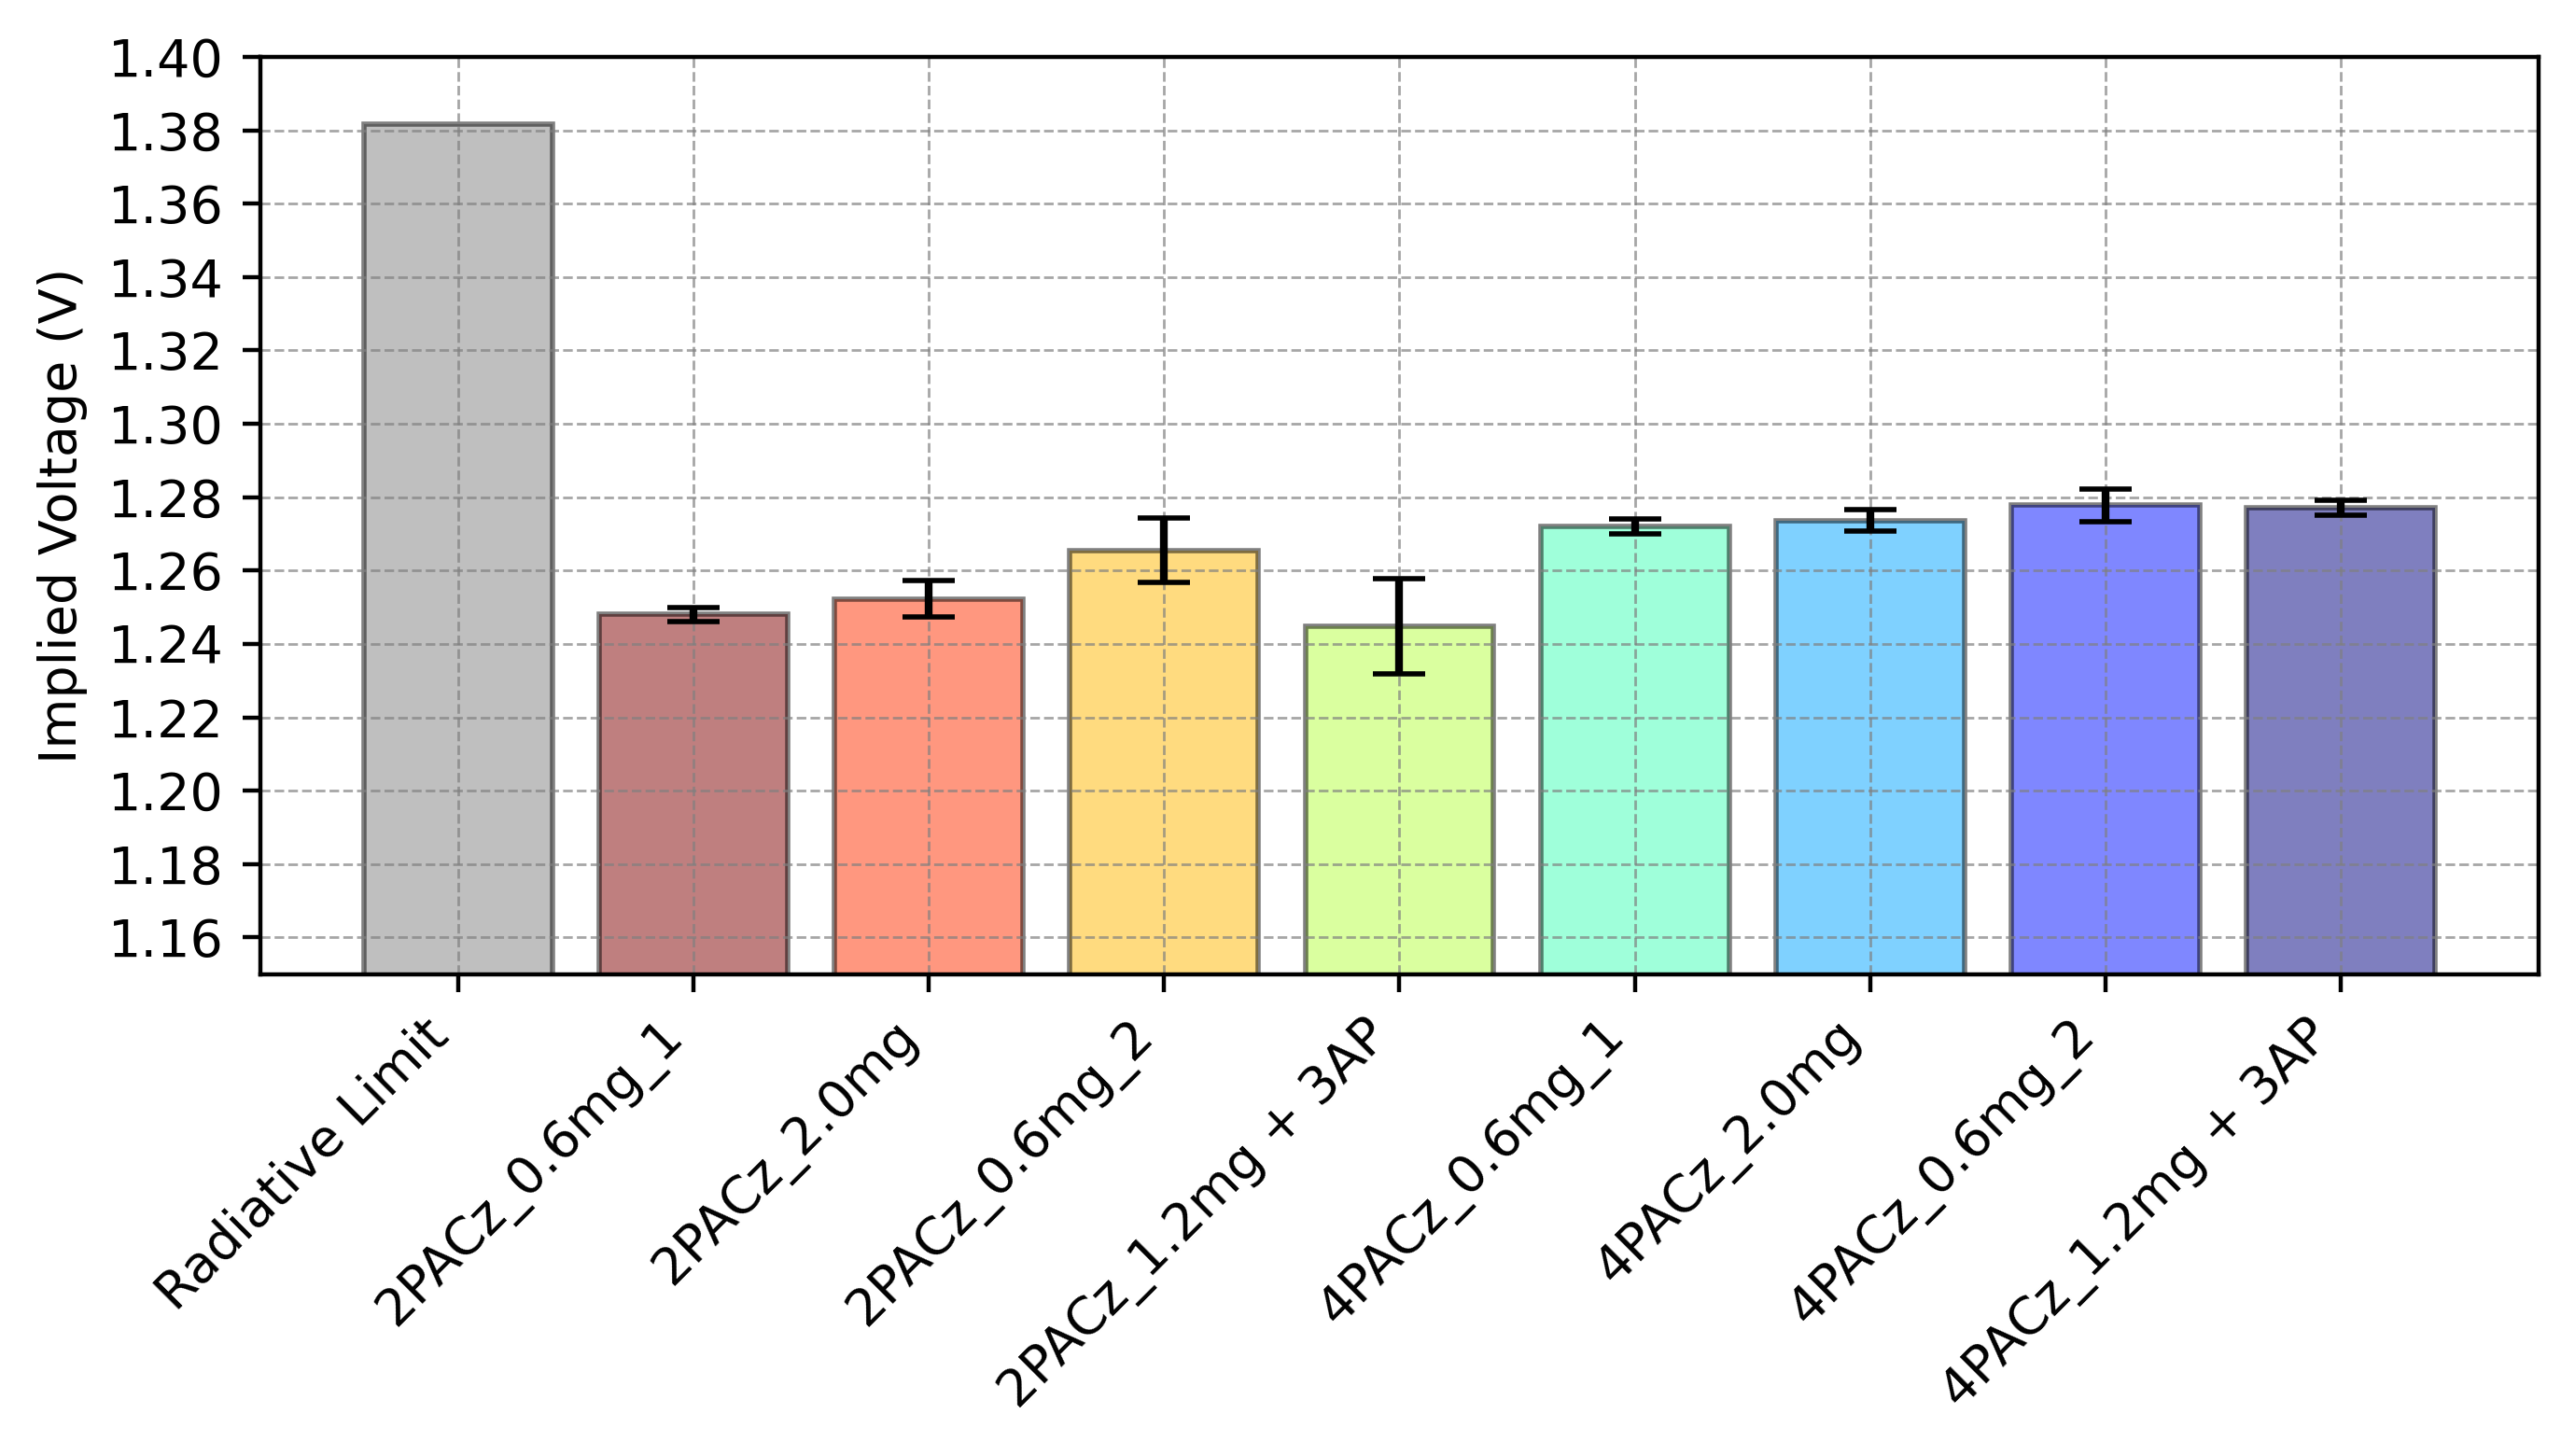

In [52]:
# Sort sample_names based on the descriptions containing '2PACz', '4PACz', 'low', and 'high'
sorted_sample_names = sorted(sample_names, key=lambda x: ('4PACz' in sample_names_description[x], '2PACz' in sample_names_description[x], 'high' in sample_names_description[x], x))

# Your existing plotting code, but use sorted_sample_names instead of sample_names
fig, axs = plt.subplots(1, 1, figsize=(7, 4), dpi=400)

colors = plt.cm.jet(np.linspace(0, 1, len(sorted_sample_names)))[::-1]

rad_limit = data[sorted_sample_names[-1]]['qfls_rad'][-1]  # Assuming this is how rad_limit is defined

axs.bar(0, rad_limit, color='gray', alpha=0.5, edgecolor='black', label='Radiative Limit')

for i, n in enumerate(sorted_sample_names):
    start_index = len(data[n]['Suns']) - len(x_filtered_data[n])

    x = data[n]['qfls'][-1]
    x_error = data[n]['qfls_err'][-1]
    axs.bar(i + 1, x, color=colors[i], alpha=0.5, edgecolor='black', yerr=x_error, capsize=5)

# Set x-axis tick positions and labels based on sorted_sample_names
axs.set_xticks(range(len(sorted_sample_names) + 1))
axs.set_xticklabels(['Radiative Limit'] + [sample_names_description[n] for n in sorted_sample_names], rotation=45, ha='right')

axs.set_ylabel('Implied Voltage (V)')
axs.set_ylim(1.15, 1.40)
axs.yaxis.set_major_locator(plt.MultipleLocator(0.02))

# Add grid lines
axs.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.tight_layout()
plt.savefig("Voc_1Sun.png", facecolor='white', bbox_inches='tight')


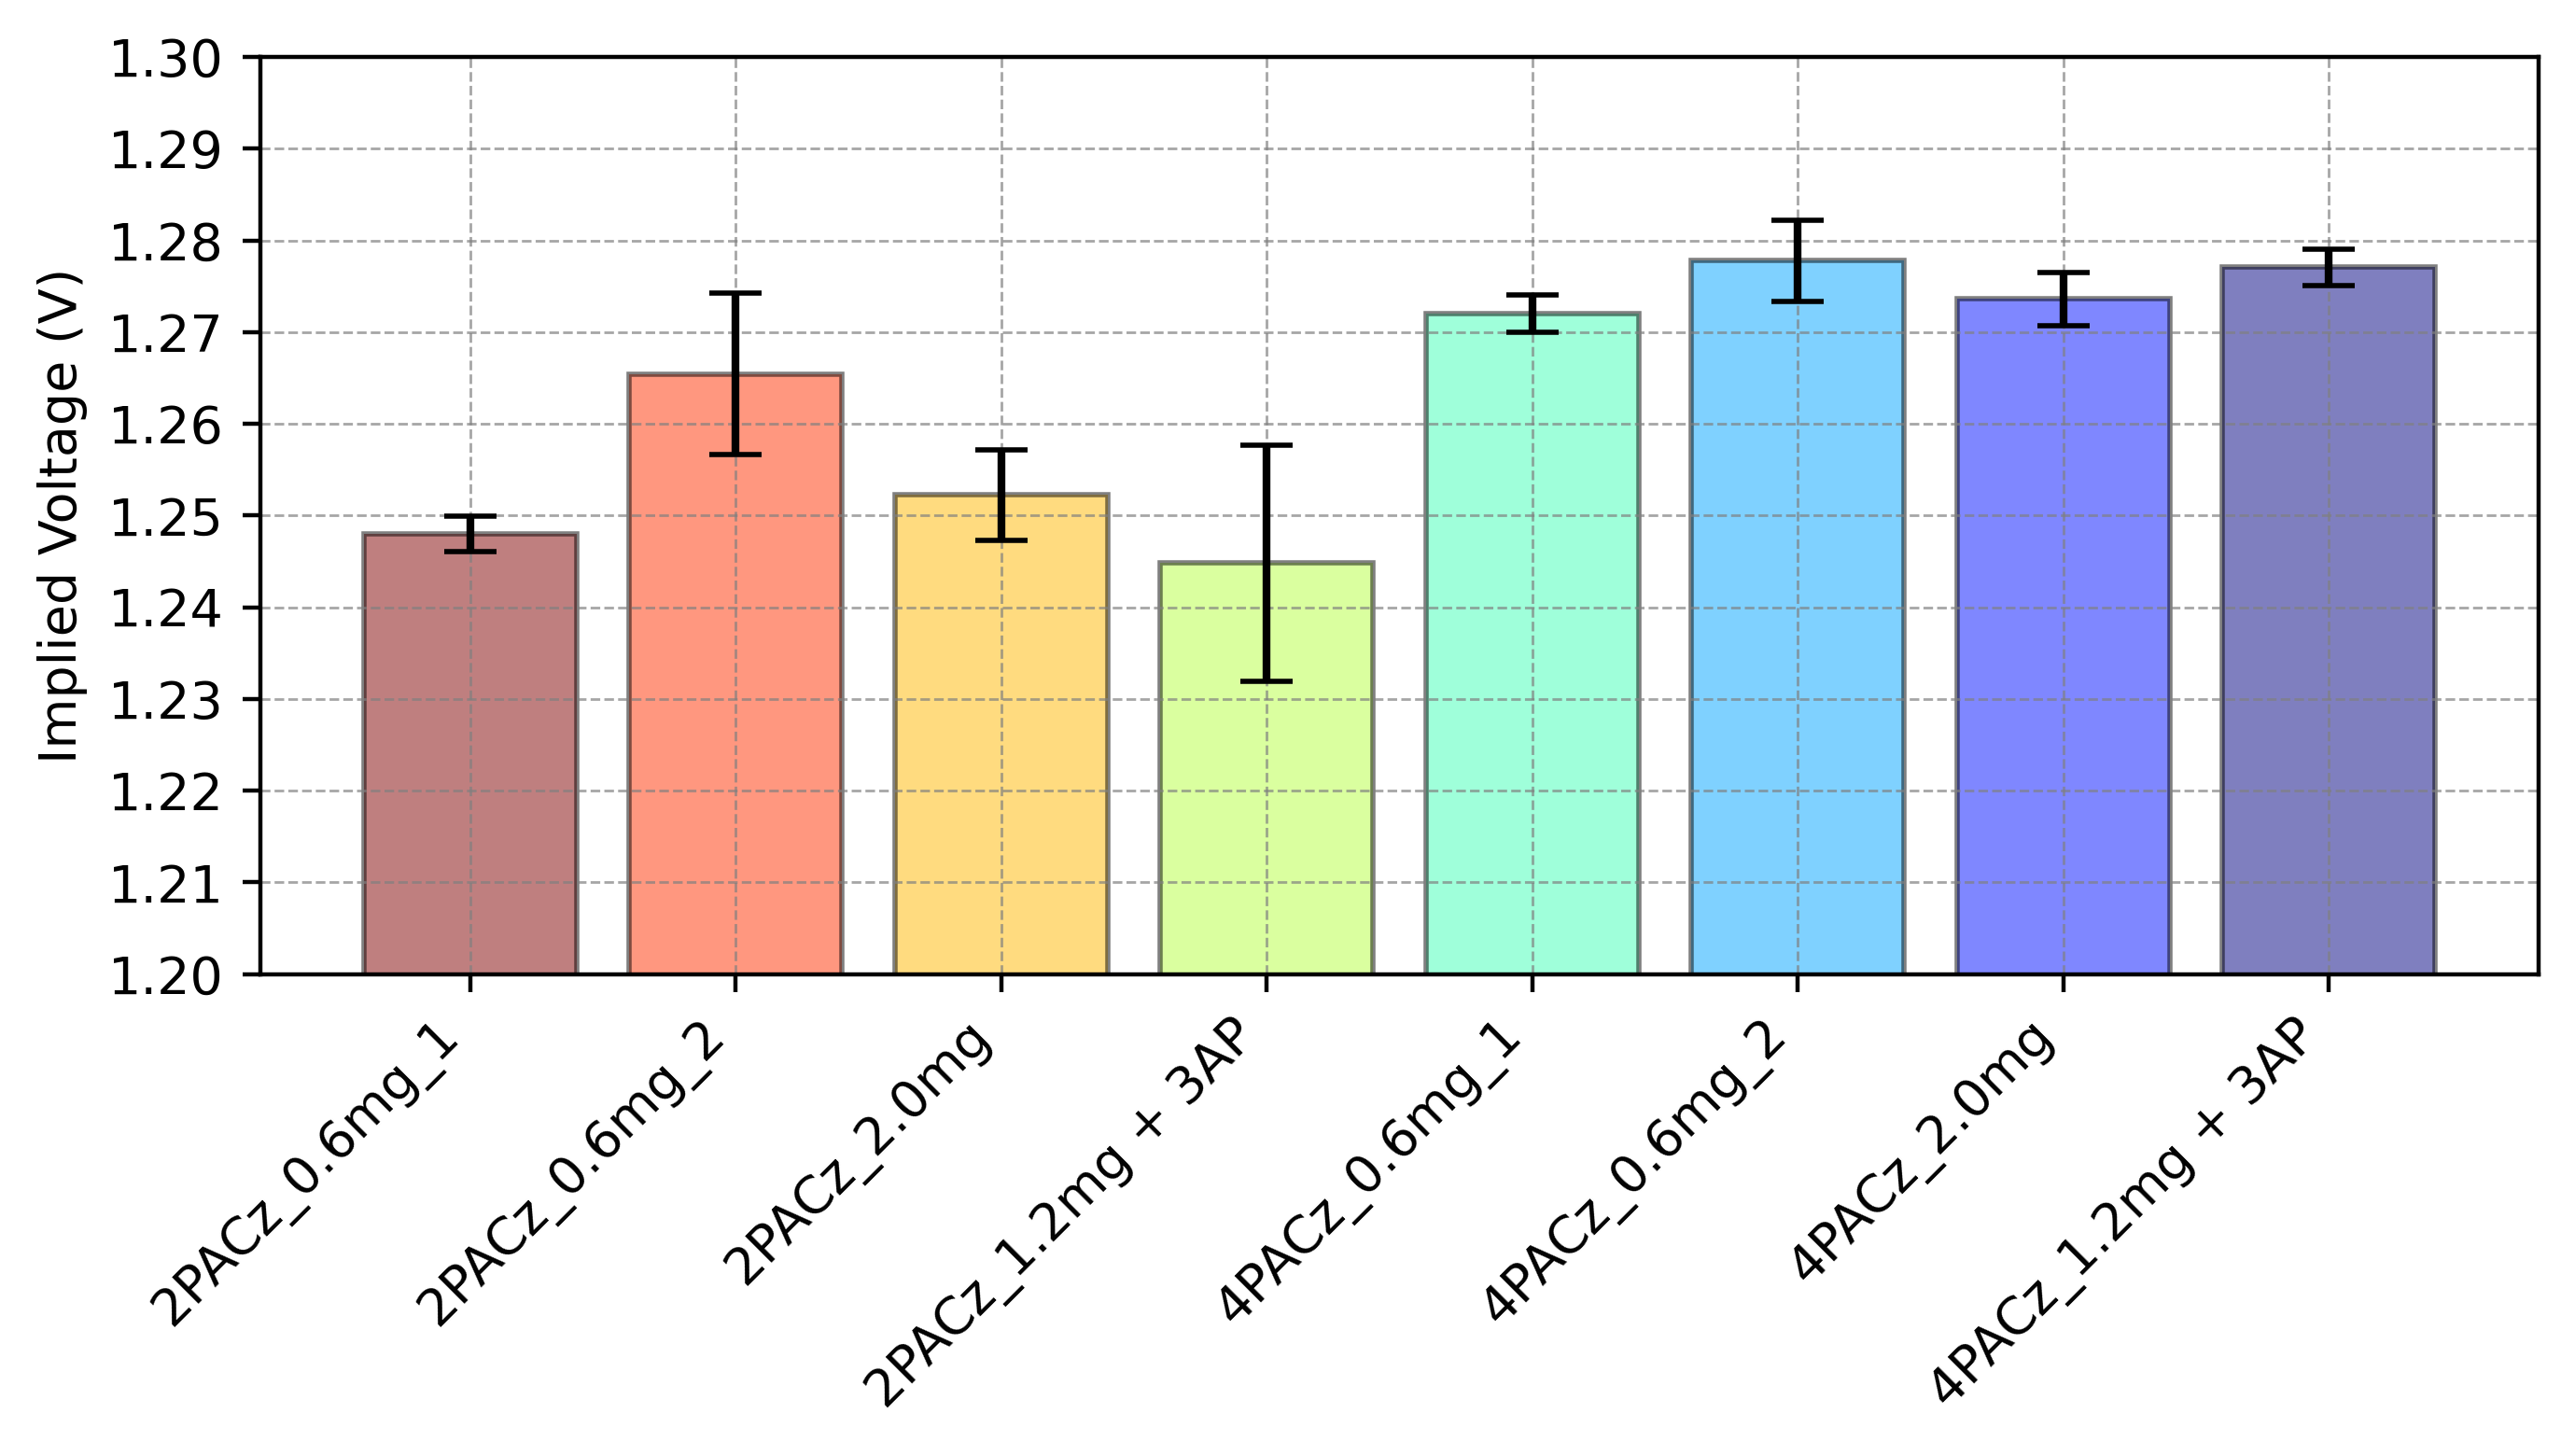

In [53]:
# Existing sample_names list (assuming it's defined somewhere in your code)
sample_names = ['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

# Custom function to extract the concentration as a float
def extract_concentration(description):
    parts = description.split('_')
    if len(parts) > 1:
        try:
            return float(parts[1].replace('mg', ''))
        except ValueError:
            return 0
    return 0

# Sort based on substance type and concentration
sorted_sample_names = sorted(sample_names, key=lambda x: ('4PACz' in sample_names_description[x], '3AP' in sample_names_description[x], extract_concentration(sample_names_description[x]), x))

fig, axs = plt.subplots(1, 1, figsize=(7, 4), dpi=400)

colors = plt.cm.jet(np.linspace(0, 1, len(sorted_sample_names)))[::-1]

for i, n in enumerate(sorted_sample_names):
    start_index = len(data[n]['Suns']) - len(x_filtered_data[n]) 

    x = data[n]['qfls'][-1]  
    x_error = data[n]['qfls_err'][-1]  
    axs.bar(i, x, color=colors[i], alpha=0.5, edgecolor='black', yerr=x_error, capsize=5)

axs.set_xticks(range(len(sorted_sample_names)))
axs.set_xticklabels([sample_names_description[n] for n in sorted_sample_names], rotation=45, ha='right')
axs.set_ylabel('Implied Voltage (V)')
axs.set_ylim(1.2, 1.30)
axs.yaxis.set_major_locator(plt.MultipleLocator(0.01))
axs.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.tight_layout()
plt.savefig("Voc_1Sun.png", facecolor='white', bbox_inches='tight')


Lets do some statistics:\
Perform difference in means\
Bonferroni correction

In [59]:
# Bonferroni correction multiple hypothesis testing:
# Significance level
alpha = 0.01  # Overall significance level

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Comparison', 'T-Statistic', 'Degrees of Freedom', 'Two-Tailed P-Value', 'Result'])

# Create a list of sample names
sample_names = list(sample_names_description.keys())

# Calculate the adjusted alpha for Bonferroni correction
num_tests = len(sample_names) * (len(sample_names) - 1) / 2  # Number of unique test pairs
alpha_Bonferroni = alpha / num_tests

# Perform the t-test for all pairs of samples
for i in range(len(sample_names)):
    for j in range(i + 1, len(sample_names)):
        sample1 = sample_names[i]
        sample2 = sample_names[j]

        # Sample 1 information
        mean1 = data[sample1]['qfls'][-1]
        std1 = data[sample1]['qfls_err'][-1]
        n1 = 10

        # Sample 2 information
        mean2 = data[sample2]['qfls'][-1]
        std2 = data[sample2]['qfls_err'][-1]
        n2 = 10

        # Calculate pooled standard deviation
        pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

        # Calculate t-statistic
        t_statistic = (mean1 - mean2) / (pooled_std * np.sqrt((1 / n1) + (1 / n2)))

        # Degrees of freedom
        df = n1 + n2 - 2

        # Calculate p-value
        p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df))

        # Interpret the results with Bonferroni correction
        if p_value < alpha_Bonferroni:
            result = "Reject the null hypothesis: There is a significant difference between the means (Bonferroni corrected)."
        else:
            result = "Fail to reject the null hypothesis: There is no significant difference between the means (Bonferroni corrected)."

        # Store results in the DataFrame
        comparison = f"{sample_names_description[sample1]} vs. {sample_names_description[sample2]}"
        results_df = results_df.append({'Comparison': comparison, 'T-Statistic': t_statistic, 
                                        'Degrees of Freedom': df, 'Two-Tailed P-Value': p_value, 'Result': result},
                                       ignore_index=True)
print(alpha_Bonferroni)
# Export the results DataFrame to a CSV file
results_df.to_csv('t_test_results_alpha0.01_Bonferroni.csv', index=False)


0.00035714285714285714


/var/folders/b5/vvl66y7519qbwz7xvyw9l0wh0000gn/T/ipykernel_7144/2865520857.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Comparison': comparison, 'T-Statistic': t_statistic,
/var/folders/b5/vvl66y7519qbwz7xvyw9l0wh0000gn/T/ipykernel_7144/2865520857.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Comparison': comparison, 'T-Statistic': t_statistic,
/var/folders/b5/vvl66y7519qbwz7xvyw9l0wh0000gn/T/ipykernel_7144/2865520857.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Comparison': comparison, 'T-Statistic': t_statistic,
/var/folders/b5/vvl66y7519qbwz7xvyw9l0wh0000gn/T/ipykernel_7144/2865520857.py:51: FutureWar